<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[21:14:54] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


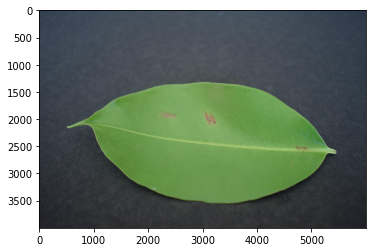

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

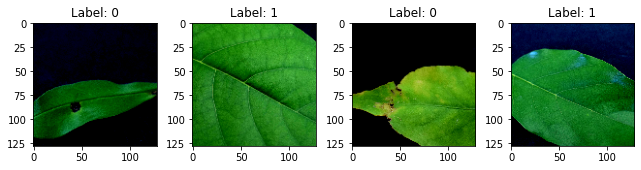

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[21:14:59] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[21:15:01] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2595649350405598 samples/sec                   batch loss = 0.7298451662063599 | accuracy = 0.4


Epoch[1] Batch[10] Speed: 1.2681995479531922 samples/sec                   batch loss = 0.5574430823326111 | accuracy = 0.55


Epoch[1] Batch[15] Speed: 1.270538812995634 samples/sec                   batch loss = 0.8434485197067261 | accuracy = 0.5333333333333333


Epoch[1] Batch[20] Speed: 1.2595264490767708 samples/sec                   batch loss = 0.5589927434921265 | accuracy = 0.525


Epoch[1] Batch[25] Speed: 1.2684592006640028 samples/sec                   batch loss = 0.5690522193908691 | accuracy = 0.55


Epoch[1] Batch[30] Speed: 1.276536642490874 samples/sec                   batch loss = 0.43944430351257324 | accuracy = 0.5916666666666667


Epoch[1] Batch[35] Speed: 1.2662990217537664 samples/sec                   batch loss = 0.41230344772338867 | accuracy = 0.6214285714285714


Epoch[1] Batch[40] Speed: 1.2637173178263499 samples/sec                   batch loss = 0.4928664267063141 | accuracy = 0.625


Epoch[1] Batch[45] Speed: 1.2592263959636223 samples/sec                   batch loss = 0.6695936918258667 | accuracy = 0.6388888888888888


Epoch[1] Batch[50] Speed: 1.254679729865555 samples/sec                   batch loss = 0.9509064555168152 | accuracy = 0.63


Epoch[1] Batch[55] Speed: 1.2558795658666555 samples/sec                   batch loss = 0.45397746562957764 | accuracy = 0.6363636363636364


Epoch[1] Batch[60] Speed: 1.266880395706813 samples/sec                   batch loss = 0.6662917137145996 | accuracy = 0.6416666666666667


Epoch[1] Batch[65] Speed: 1.2641196130941124 samples/sec                   batch loss = 0.14550645649433136 | accuracy = 0.6653846153846154


Epoch[1] Batch[70] Speed: 1.2608740058354033 samples/sec                   batch loss = 0.5028485655784607 | accuracy = 0.6714285714285714


Epoch[1] Batch[75] Speed: 1.2618843842370053 samples/sec                   batch loss = 0.593551516532898 | accuracy = 0.67


Epoch[1] Batch[80] Speed: 1.2627599812978147 samples/sec                   batch loss = 1.8750907182693481 | accuracy = 0.66875


Epoch[1] Batch[85] Speed: 1.259397391698999 samples/sec                   batch loss = 0.7200537323951721 | accuracy = 0.6705882352941176


Epoch[1] Batch[90] Speed: 1.2603627006256808 samples/sec                   batch loss = 0.5042790770530701 | accuracy = 0.6694444444444444


Epoch[1] Batch[95] Speed: 1.261014455292288 samples/sec                   batch loss = 0.7332702875137329 | accuracy = 0.6684210526315789


Epoch[1] Batch[100] Speed: 1.258864896204823 samples/sec                   batch loss = 0.7242352962493896 | accuracy = 0.6575


Epoch[1] Batch[105] Speed: 1.2585272053141765 samples/sec                   batch loss = 0.5402133464813232 | accuracy = 0.6666666666666666


Epoch[1] Batch[110] Speed: 1.2546683764297684 samples/sec                   batch loss = 0.6423084735870361 | accuracy = 0.6659090909090909


Epoch[1] Batch[115] Speed: 1.2536242702479345 samples/sec                   batch loss = 0.9078340530395508 | accuracy = 0.658695652173913


Epoch[1] Batch[120] Speed: 1.2565281967004145 samples/sec                   batch loss = 0.32460710406303406 | accuracy = 0.6625


Epoch[1] Batch[125] Speed: 1.2591841504402848 samples/sec                   batch loss = 0.5727323889732361 | accuracy = 0.652


Epoch[1] Batch[130] Speed: 1.2453103649505872 samples/sec                   batch loss = 0.26434630155563354 | accuracy = 0.6576923076923077


Epoch[1] Batch[135] Speed: 1.2562463136567874 samples/sec                   batch loss = 0.5851641297340393 | accuracy = 0.6592592592592592


Epoch[1] Batch[140] Speed: 1.261516234716146 samples/sec                   batch loss = 0.25659942626953125 | accuracy = 0.6660714285714285


Epoch[1] Batch[145] Speed: 1.2359926564843655 samples/sec                   batch loss = 0.3143208622932434 | accuracy = 0.6672413793103448


Epoch[1] Batch[150] Speed: 1.2586068900732026 samples/sec                   batch loss = 0.5161914825439453 | accuracy = 0.665


Epoch[1] Batch[155] Speed: 1.2578081387842999 samples/sec                   batch loss = 0.7660007476806641 | accuracy = 0.6693548387096774


Epoch[1] Batch[160] Speed: 1.2615122507676915 samples/sec                   batch loss = 0.7363178730010986 | accuracy = 0.6703125


Epoch[1] Batch[165] Speed: 1.2603005917559809 samples/sec                   batch loss = 0.42099738121032715 | accuracy = 0.6742424242424242


Epoch[1] Batch[170] Speed: 1.2624407163907045 samples/sec                   batch loss = 0.5511227250099182 | accuracy = 0.6720588235294118


Epoch[1] Batch[175] Speed: 1.2562023866714427 samples/sec                   batch loss = 0.6667316555976868 | accuracy = 0.6685714285714286


Epoch[1] Batch[180] Speed: 1.2632804630246928 samples/sec                   batch loss = 0.6819326877593994 | accuracy = 0.6625


Epoch[1] Batch[185] Speed: 1.263027204685088 samples/sec                   batch loss = 0.6143191456794739 | accuracy = 0.6608108108108108


Epoch[1] Batch[190] Speed: 1.2583799472457795 samples/sec                   batch loss = 0.9308450222015381 | accuracy = 0.6631578947368421


Epoch[1] Batch[195] Speed: 1.268865480814187 samples/sec                   batch loss = 0.7319310903549194 | accuracy = 0.6666666666666666


Epoch[1] Batch[200] Speed: 1.262874328798501 samples/sec                   batch loss = 0.8053648471832275 | accuracy = 0.6625


Epoch[1] Batch[205] Speed: 1.2587884843907586 samples/sec                   batch loss = 0.6582109332084656 | accuracy = 0.6621951219512195


Epoch[1] Batch[210] Speed: 1.2690116518080177 samples/sec                   batch loss = 0.4984079599380493 | accuracy = 0.6619047619047619


Epoch[1] Batch[215] Speed: 1.262869195549055 samples/sec                   batch loss = 0.5723791122436523 | accuracy = 0.6627906976744186


Epoch[1] Batch[220] Speed: 1.260314414237035 samples/sec                   batch loss = 0.43222901225090027 | accuracy = 0.6625


Epoch[1] Batch[225] Speed: 1.2549580940501077 samples/sec                   batch loss = 0.41687649488449097 | accuracy = 0.6644444444444444


Epoch[1] Batch[230] Speed: 1.2577105464834522 samples/sec                   batch loss = 0.8923400640487671 | accuracy = 0.6630434782608695


Epoch[1] Batch[235] Speed: 1.2570076694687056 samples/sec                   batch loss = 0.6156242489814758 | accuracy = 0.6606382978723404


Epoch[1] Batch[240] Speed: 1.2575543360367993 samples/sec                   batch loss = 0.5417664051055908 | accuracy = 0.6635416666666667


Epoch[1] Batch[245] Speed: 1.2554671835041054 samples/sec                   batch loss = 0.317270964384079 | accuracy = 0.6632653061224489


Epoch[1] Batch[250] Speed: 1.262745154709692 samples/sec                   batch loss = 2.027927875518799 | accuracy = 0.662


Epoch[1] Batch[255] Speed: 1.2560514404726353 samples/sec                   batch loss = 0.3959715664386749 | accuracy = 0.6656862745098039


Epoch[1] Batch[260] Speed: 1.25674251619729 samples/sec                   batch loss = 0.37284156680107117 | accuracy = 0.6673076923076923


Epoch[1] Batch[265] Speed: 1.2610538853256243 samples/sec                   batch loss = 1.4816274642944336 | accuracy = 0.6650943396226415


Epoch[1] Batch[270] Speed: 1.2637727193873889 samples/sec                   batch loss = 0.6051758527755737 | accuracy = 0.6666666666666666


Epoch[1] Batch[275] Speed: 1.2597164431838181 samples/sec                   batch loss = 0.28401002287864685 | accuracy = 0.6681818181818182


Epoch[1] Batch[280] Speed: 1.262230906661645 samples/sec                   batch loss = 0.15436221659183502 | accuracy = 0.6732142857142858


Epoch[1] Batch[285] Speed: 1.2554128834966851 samples/sec                   batch loss = 0.32957321405410767 | accuracy = 0.6763157894736842


Epoch[1] Batch[290] Speed: 1.2602578954587582 samples/sec                   batch loss = 0.7108350396156311 | accuracy = 0.6741379310344827


Epoch[1] Batch[295] Speed: 1.255388459419419 samples/sec                   batch loss = 0.40859776735305786 | accuracy = 0.6745762711864407


Epoch[1] Batch[300] Speed: 1.2554593858093683 samples/sec                   batch loss = 0.6358137726783752 | accuracy = 0.6741666666666667


Epoch[1] Batch[305] Speed: 1.261833513677108 samples/sec                   batch loss = 0.8452004194259644 | accuracy = 0.671311475409836


Epoch[1] Batch[310] Speed: 1.2606154597539212 samples/sec                   batch loss = 0.7521405816078186 | accuracy = 0.6701612903225806


Epoch[1] Batch[315] Speed: 1.2624108885732255 samples/sec                   batch loss = 0.6282374858856201 | accuracy = 0.669047619047619


Epoch[1] Batch[320] Speed: 1.2673873339498078 samples/sec                   batch loss = 0.5348339080810547 | accuracy = 0.6703125


Epoch[1] Batch[325] Speed: 1.2630194078798538 samples/sec                   batch loss = 0.35178306698799133 | accuracy = 0.6738461538461539


Epoch[1] Batch[330] Speed: 1.2645121572343379 samples/sec                   batch loss = 0.2630423605442047 | accuracy = 0.6757575757575758


Epoch[1] Batch[335] Speed: 1.2672989709909581 samples/sec                   batch loss = 0.5939944386482239 | accuracy = 0.6761194029850747


Epoch[1] Batch[340] Speed: 1.261780369711855 samples/sec                   batch loss = 0.44443002343177795 | accuracy = 0.6772058823529412


Epoch[1] Batch[345] Speed: 1.2674802097113707 samples/sec                   batch loss = 0.740993082523346 | accuracy = 0.6782608695652174


Epoch[1] Batch[350] Speed: 1.2639053411347867 samples/sec                   batch loss = 0.6701329946517944 | accuracy = 0.6764285714285714


Epoch[1] Batch[355] Speed: 1.2698094190233122 samples/sec                   batch loss = 0.3562219738960266 | accuracy = 0.6774647887323944


Epoch[1] Batch[360] Speed: 1.2612598904671872 samples/sec                   batch loss = 0.29805535078048706 | accuracy = 0.6805555555555556


Epoch[1] Batch[365] Speed: 1.2597098222162888 samples/sec                   batch loss = 0.8737670183181763 | accuracy = 0.6815068493150684


Epoch[1] Batch[370] Speed: 1.266636880409486 samples/sec                   batch loss = 0.42359793186187744 | accuracy = 0.6804054054054054


Epoch[1] Batch[375] Speed: 1.2597061334217126 samples/sec                   batch loss = 0.9608352184295654 | accuracy = 0.682


Epoch[1] Batch[380] Speed: 1.265125089451947 samples/sec                   batch loss = 0.3942272663116455 | accuracy = 0.6822368421052631


Epoch[1] Batch[385] Speed: 1.2676813275898897 samples/sec                   batch loss = 0.5177270770072937 | accuracy = 0.6818181818181818


Epoch[1] Batch[390] Speed: 1.2719561428314743 samples/sec                   batch loss = 0.4206075668334961 | accuracy = 0.6807692307692308


Epoch[1] Batch[395] Speed: 1.261299525498266 samples/sec                   batch loss = 0.4643672704696655 | accuracy = 0.6810126582278481


Epoch[1] Batch[400] Speed: 1.267821669050587 samples/sec                   batch loss = 0.7566731572151184 | accuracy = 0.68125


Epoch[1] Batch[405] Speed: 1.2688229698999316 samples/sec                   batch loss = 0.42561352252960205 | accuracy = 0.6833333333333333


Epoch[1] Batch[410] Speed: 1.2677642833604472 samples/sec                   batch loss = 0.4488157331943512 | accuracy = 0.6841463414634147


Epoch[1] Batch[415] Speed: 1.2615281867124903 samples/sec                   batch loss = 0.42385900020599365 | accuracy = 0.686144578313253


Epoch[1] Batch[420] Speed: 1.261914471927522 samples/sec                   batch loss = 0.18673555552959442 | accuracy = 0.6869047619047619


Epoch[1] Batch[425] Speed: 1.262037780006561 samples/sec                   batch loss = 0.3859468400478363 | accuracy = 0.6876470588235294


Epoch[1] Batch[430] Speed: 1.2619004244991312 samples/sec                   batch loss = 0.4320218563079834 | accuracy = 0.6901162790697675


Epoch[1] Batch[435] Speed: 1.2636633488116356 samples/sec                   batch loss = 0.44832706451416016 | accuracy = 0.6902298850574713


Epoch[1] Batch[440] Speed: 1.2628608303430757 samples/sec                   batch loss = 1.0292938947677612 | accuracy = 0.6909090909090909


Epoch[1] Batch[445] Speed: 1.259004237049653 samples/sec                   batch loss = 0.5492902994155884 | accuracy = 0.6915730337078652


Epoch[1] Batch[450] Speed: 1.2612811299826805 samples/sec                   batch loss = 1.7412701845169067 | accuracy = 0.6916666666666667


Epoch[1] Batch[455] Speed: 1.2594477823847585 samples/sec                   batch loss = 0.5997020602226257 | accuracy = 0.6906593406593406


Epoch[1] Batch[460] Speed: 1.2551710330873997 samples/sec                   batch loss = 0.16994261741638184 | accuracy = 0.691304347826087


Epoch[1] Batch[465] Speed: 1.2610152135389063 samples/sec                   batch loss = 0.791146457195282 | accuracy = 0.6908602150537635


Epoch[1] Batch[470] Speed: 1.2588451548103743 samples/sec                   batch loss = 0.3371746838092804 | accuracy = 0.6914893617021277


Epoch[1] Batch[475] Speed: 1.2631376063681132 samples/sec                   batch loss = 0.8575087189674377 | accuracy = 0.6921052631578948


Epoch[1] Batch[480] Speed: 1.2653000767149472 samples/sec                   batch loss = 1.5023869276046753 | accuracy = 0.690625


Epoch[1] Batch[485] Speed: 1.2669404759351617 samples/sec                   batch loss = 1.3999508619308472 | accuracy = 0.6896907216494845


Epoch[1] Batch[490] Speed: 1.2593153381987903 samples/sec                   batch loss = 0.23960401117801666 | accuracy = 0.6903061224489796


Epoch[1] Batch[495] Speed: 1.2610769189138809 samples/sec                   batch loss = 0.3345406949520111 | accuracy = 0.6909090909090909


Epoch[1] Batch[500] Speed: 1.2616342468865438 samples/sec                   batch loss = 0.644356906414032 | accuracy = 0.691


Epoch[1] Batch[505] Speed: 1.2560406264056065 samples/sec                   batch loss = 0.2706586420536041 | accuracy = 0.6925742574257425


Epoch[1] Batch[510] Speed: 1.2549397891725305 samples/sec                   batch loss = 0.5073081254959106 | accuracy = 0.6941176470588235


Epoch[1] Batch[515] Speed: 1.265060220977395 samples/sec                   batch loss = 0.3901445269584656 | accuracy = 0.695631067961165


Epoch[1] Batch[520] Speed: 1.2614905292056449 samples/sec                   batch loss = 0.772912323474884 | accuracy = 0.6951923076923077


Epoch[1] Batch[525] Speed: 1.266547283458269 samples/sec                   batch loss = 0.26206764578819275 | accuracy = 0.6961904761904761


Epoch[1] Batch[530] Speed: 1.2584833074768864 samples/sec                   batch loss = 0.47084876894950867 | accuracy = 0.6957547169811321


Epoch[1] Batch[535] Speed: 1.2592695895075678 samples/sec                   batch loss = 0.3703942894935608 | accuracy = 0.6967289719626168


Epoch[1] Batch[540] Speed: 1.2609432789514547 samples/sec                   batch loss = 0.24178776144981384 | accuracy = 0.6967592592592593


Epoch[1] Batch[545] Speed: 1.2615544629292592 samples/sec                   batch loss = 0.3864036500453949 | accuracy = 0.6981651376146789


Epoch[1] Batch[550] Speed: 1.260947827931277 samples/sec                   batch loss = 0.7118191719055176 | accuracy = 0.6963636363636364


Epoch[1] Batch[555] Speed: 1.2601915373335104 samples/sec                   batch loss = 0.5512677431106567 | accuracy = 0.6972972972972973


Epoch[1] Batch[560] Speed: 1.2628528454771113 samples/sec                   batch loss = 0.7045525312423706 | accuracy = 0.6977678571428572


Epoch[1] Batch[565] Speed: 1.2648076788827558 samples/sec                   batch loss = 0.28486672043800354 | accuracy = 0.6982300884955752


Epoch[1] Batch[570] Speed: 1.2616557836438214 samples/sec                   batch loss = 0.31037554144859314 | accuracy = 0.7


Epoch[1] Batch[575] Speed: 1.2601439266080956 samples/sec                   batch loss = 0.5391939878463745 | accuracy = 0.701304347826087


Epoch[1] Batch[580] Speed: 1.2586958392449212 samples/sec                   batch loss = 0.43545079231262207 | accuracy = 0.7008620689655173


Epoch[1] Batch[585] Speed: 1.2544094612822985 samples/sec                   batch loss = 0.8043806552886963 | accuracy = 0.7008547008547008


Epoch[1] Batch[590] Speed: 1.2570499574457692 samples/sec                   batch loss = 0.25588905811309814 | accuracy = 0.7008474576271186


Epoch[1] Batch[595] Speed: 1.2581776180155337 samples/sec                   batch loss = 0.5852779746055603 | accuracy = 0.7


Epoch[1] Batch[600] Speed: 1.2586479637653294 samples/sec                   batch loss = 0.3008936643600464 | accuracy = 0.7


Epoch[1] Batch[605] Speed: 1.2665313160689102 samples/sec                   batch loss = 0.20959383249282837 | accuracy = 0.7012396694214876


Epoch[1] Batch[610] Speed: 1.27064254438482 samples/sec                   batch loss = 0.4757520258426666 | accuracy = 0.7020491803278689


Epoch[1] Batch[615] Speed: 1.2679297483610914 samples/sec                   batch loss = 0.26398441195487976 | accuracy = 0.7020325203252032


Epoch[1] Batch[620] Speed: 1.2624969561098889 samples/sec                   batch loss = 0.43336814641952515 | accuracy = 0.7028225806451613


Epoch[1] Batch[625] Speed: 1.2624170630057419 samples/sec                   batch loss = 0.8351430892944336 | accuracy = 0.7016


Epoch[1] Batch[630] Speed: 1.2623194190561355 samples/sec                   batch loss = 1.3322557210922241 | accuracy = 0.7015873015873015


Epoch[1] Batch[635] Speed: 1.2686937273480174 samples/sec                   batch loss = 0.4307798743247986 | accuracy = 0.7023622047244095


Epoch[1] Batch[640] Speed: 1.2649010352271572 samples/sec                   batch loss = 0.6925066709518433 | accuracy = 0.7015625


Epoch[1] Batch[645] Speed: 1.2560125107027702 samples/sec                   batch loss = 0.632503867149353 | accuracy = 0.7011627906976744


Epoch[1] Batch[650] Speed: 1.256022760094132 samples/sec                   batch loss = 0.7109867930412292 | accuracy = 0.7007692307692308


Epoch[1] Batch[655] Speed: 1.2592773400850206 samples/sec                   batch loss = 0.2995588779449463 | accuracy = 0.7007633587786259


Epoch[1] Batch[660] Speed: 1.2599796357108344 samples/sec                   batch loss = 0.5721211433410645 | accuracy = 0.7018939393939394


Epoch[1] Batch[665] Speed: 1.2680170492700322 samples/sec                   batch loss = 0.3857605457305908 | accuracy = 0.7030075187969925


Epoch[1] Batch[670] Speed: 1.269478607173578 samples/sec                   batch loss = 0.24599210917949677 | accuracy = 0.7022388059701492


Epoch[1] Batch[675] Speed: 1.26497103768588 samples/sec                   batch loss = 0.6122220158576965 | accuracy = 0.7018518518518518


Epoch[1] Batch[680] Speed: 1.2691647691597763 samples/sec                   batch loss = 0.3753865659236908 | accuracy = 0.700735294117647


Epoch[1] Batch[685] Speed: 1.260917596785284 samples/sec                   batch loss = 0.5783824920654297 | accuracy = 0.7014598540145985


Epoch[1] Batch[690] Speed: 1.26737000503104 samples/sec                   batch loss = 0.574123203754425 | accuracy = 0.7007246376811594


Epoch[1] Batch[695] Speed: 1.2620275271461807 samples/sec                   batch loss = 0.9886623620986938 | accuracy = 0.7010791366906475


Epoch[1] Batch[700] Speed: 1.2722095220286116 samples/sec                   batch loss = 0.34391677379608154 | accuracy = 0.7003571428571429


Epoch[1] Batch[705] Speed: 1.264374643770403 samples/sec                   batch loss = 0.9179179072380066 | accuracy = 0.7


Epoch[1] Batch[710] Speed: 1.2709548030140112 samples/sec                   batch loss = 0.5503183007240295 | accuracy = 0.6992957746478873


Epoch[1] Batch[715] Speed: 1.2695702525592745 samples/sec                   batch loss = 0.3602348268032074 | accuracy = 0.7006993006993008


Epoch[1] Batch[720] Speed: 1.2671303209800606 samples/sec                   batch loss = 0.5581197738647461 | accuracy = 0.7003472222222222


Epoch[1] Batch[725] Speed: 1.272530948567566 samples/sec                   batch loss = 0.6321607828140259 | accuracy = 0.7006896551724138


Epoch[1] Batch[730] Speed: 1.2679440261726518 samples/sec                   batch loss = 0.30157938599586487 | accuracy = 0.7013698630136986


Epoch[1] Batch[735] Speed: 1.2752888879429476 samples/sec                   batch loss = 0.4330640733242035 | accuracy = 0.7020408163265306


Epoch[1] Batch[740] Speed: 1.265023306153942 samples/sec                   batch loss = 0.5985469222068787 | accuracy = 0.7016891891891892


Epoch[1] Batch[745] Speed: 1.2637915684485694 samples/sec                   batch loss = 0.3756696283817291 | accuracy = 0.7013422818791947


Epoch[1] Batch[750] Speed: 1.2647318787106308 samples/sec                   batch loss = 0.33290696144104004 | accuracy = 0.702


Epoch[1] Batch[755] Speed: 1.268347195614389 samples/sec                   batch loss = 0.322422593832016 | accuracy = 0.702317880794702


Epoch[1] Batch[760] Speed: 1.2679915573119591 samples/sec                   batch loss = 0.365199476480484 | accuracy = 0.7016447368421053


Epoch[1] Batch[765] Speed: 1.267986094882865 samples/sec                   batch loss = 0.9062647819519043 | accuracy = 0.7019607843137254


Epoch[1] Batch[770] Speed: 1.262970442340349 samples/sec                   batch loss = 0.35879820585250854 | accuracy = 0.702922077922078


Epoch[1] Batch[775] Speed: 1.2710167146735654 samples/sec                   batch loss = 0.47735804319381714 | accuracy = 0.7016129032258065


Epoch[1] Batch[780] Speed: 1.2705743184013554 samples/sec                   batch loss = 0.6820530295372009 | accuracy = 0.7012820512820512


Epoch[1] Batch[785] Speed: 1.26683572190622 samples/sec                   batch loss = 0.7055771946907043 | accuracy = 0.7019108280254777


[Epoch 1] training: accuracy=0.7024111675126904
[Epoch 1] time cost: 651.1223673820496
[Epoch 1] validation: validation accuracy=0.7522222222222222


Epoch[2] Batch[5] Speed: 1.2577640082159562 samples/sec                   batch loss = 0.8738221526145935 | accuracy = 0.85


Epoch[2] Batch[10] Speed: 1.2538894211869234 samples/sec                   batch loss = 0.40138107538223267 | accuracy = 0.8


Epoch[2] Batch[15] Speed: 1.2569837483541495 samples/sec                   batch loss = 0.815435528755188 | accuracy = 0.8


Epoch[2] Batch[20] Speed: 1.2613171629397506 samples/sec                   batch loss = 0.3098561763763428 | accuracy = 0.775


Epoch[2] Batch[25] Speed: 1.261208975434443 samples/sec                   batch loss = 0.6044357419013977 | accuracy = 0.77


Epoch[2] Batch[30] Speed: 1.260623700517475 samples/sec                   batch loss = 0.7349447011947632 | accuracy = 0.7333333333333333


Epoch[2] Batch[35] Speed: 1.2628409634230204 samples/sec                   batch loss = 0.5006220936775208 | accuracy = 0.7357142857142858


Epoch[2] Batch[40] Speed: 1.2585886674315474 samples/sec                   batch loss = 0.577651858329773 | accuracy = 0.75


Epoch[2] Batch[45] Speed: 1.2589515200722778 samples/sec                   batch loss = 1.2451919317245483 | accuracy = 0.7388888888888889


Epoch[2] Batch[50] Speed: 1.263682860886329 samples/sec                   batch loss = 0.3970719575881958 | accuracy = 0.75


Epoch[2] Batch[55] Speed: 1.2663430842080514 samples/sec                   batch loss = 0.7261373996734619 | accuracy = 0.7363636363636363


Epoch[2] Batch[60] Speed: 1.2648402900538407 samples/sec                   batch loss = 0.3914388120174408 | accuracy = 0.7416666666666667


Epoch[2] Batch[65] Speed: 1.2669642034547495 samples/sec                   batch loss = 0.6879862546920776 | accuracy = 0.7384615384615385


Epoch[2] Batch[70] Speed: 1.2643423424509703 samples/sec                   batch loss = 0.9985008239746094 | accuracy = 0.7428571428571429


Epoch[2] Batch[75] Speed: 1.2644314371125482 samples/sec                   batch loss = 0.3927769362926483 | accuracy = 0.7433333333333333


Epoch[2] Batch[80] Speed: 1.2638708739407298 samples/sec                   batch loss = 0.279183566570282 | accuracy = 0.746875


Epoch[2] Batch[85] Speed: 1.2579317774428902 samples/sec                   batch loss = 0.16715073585510254 | accuracy = 0.7470588235294118


Epoch[2] Batch[90] Speed: 1.27339712811165 samples/sec                   batch loss = 0.21779651939868927 | accuracy = 0.7527777777777778


Epoch[2] Batch[95] Speed: 1.2604096650547825 samples/sec                   batch loss = 0.30651989579200745 | accuracy = 0.7552631578947369


Epoch[2] Batch[100] Speed: 1.2699333136529132 samples/sec                   batch loss = 0.5554752945899963 | accuracy = 0.7575


Epoch[2] Batch[105] Speed: 1.267642152484122 samples/sec                   batch loss = 0.21984171867370605 | accuracy = 0.7595238095238095


Epoch[2] Batch[110] Speed: 1.2649006537635945 samples/sec                   batch loss = 1.0761957168579102 | accuracy = 0.759090909090909


Epoch[2] Batch[115] Speed: 1.276222023716566 samples/sec                   batch loss = 0.5801733136177063 | accuracy = 0.7630434782608696


Epoch[2] Batch[120] Speed: 1.2602436008925928 samples/sec                   batch loss = 0.5729988217353821 | accuracy = 0.7583333333333333


Epoch[2] Batch[125] Speed: 1.2611858422154067 samples/sec                   batch loss = 0.6021597385406494 | accuracy = 0.754


Epoch[2] Batch[130] Speed: 1.2671993261429364 samples/sec                   batch loss = 0.5316085815429688 | accuracy = 0.7538461538461538


Epoch[2] Batch[135] Speed: 1.2544199659037236 samples/sec                   batch loss = 0.9093272089958191 | accuracy = 0.7481481481481481


Epoch[2] Batch[140] Speed: 1.2608483264909562 samples/sec                   batch loss = 0.34520861506462097 | accuracy = 0.7482142857142857


Epoch[2] Batch[145] Speed: 1.2621223724616073 samples/sec                   batch loss = 0.24504035711288452 | accuracy = 0.75


Epoch[2] Batch[150] Speed: 1.2599417867377158 samples/sec                   batch loss = 0.18244163691997528 | accuracy = 0.7566666666666667


Epoch[2] Batch[155] Speed: 1.2600961301944873 samples/sec                   batch loss = 0.3516906201839447 | accuracy = 0.7580645161290323


Epoch[2] Batch[160] Speed: 1.2620359762505293 samples/sec                   batch loss = 0.5486486554145813 | accuracy = 0.759375


Epoch[2] Batch[165] Speed: 1.262914540696308 samples/sec                   batch loss = 0.29254698753356934 | accuracy = 0.7621212121212121


Epoch[2] Batch[170] Speed: 1.2567039201137005 samples/sec                   batch loss = 0.41392603516578674 | accuracy = 0.7617647058823529


Epoch[2] Batch[175] Speed: 1.2569814881384342 samples/sec                   batch loss = 0.2570231854915619 | accuracy = 0.7685714285714286


Epoch[2] Batch[180] Speed: 1.2544964110812997 samples/sec                   batch loss = 0.5272864103317261 | accuracy = 0.7694444444444445


Epoch[2] Batch[185] Speed: 1.2619406693186361 samples/sec                   batch loss = 0.5937305092811584 | accuracy = 0.768918918918919


Epoch[2] Batch[190] Speed: 1.260224668191556 samples/sec                   batch loss = 0.6991206407546997 | accuracy = 0.7618421052631579


Epoch[2] Batch[195] Speed: 1.2648413389790705 samples/sec                   batch loss = 0.16683118045330048 | accuracy = 0.7653846153846153


Epoch[2] Batch[200] Speed: 1.2575039082406483 samples/sec                   batch loss = 0.2871069610118866 | accuracy = 0.76875


Epoch[2] Batch[205] Speed: 1.2639771379562392 samples/sec                   batch loss = 0.23559829592704773 | accuracy = 0.7682926829268293


Epoch[2] Batch[210] Speed: 1.2664726130805 samples/sec                   batch loss = 0.6537936329841614 | accuracy = 0.7666666666666667


Epoch[2] Batch[215] Speed: 1.2610168248159985 samples/sec                   batch loss = 0.4345729649066925 | accuracy = 0.7686046511627908


Epoch[2] Batch[220] Speed: 1.2572547506149618 samples/sec                   batch loss = 0.6738945841789246 | accuracy = 0.7670454545454546


Epoch[2] Batch[225] Speed: 1.2592784743238699 samples/sec                   batch loss = 0.13830454647541046 | accuracy = 0.77


Epoch[2] Batch[230] Speed: 1.2586778973170032 samples/sec                   batch loss = 0.37955066561698914 | accuracy = 0.7673913043478261


Epoch[2] Batch[235] Speed: 1.2570880096387744 samples/sec                   batch loss = 0.5788766741752625 | accuracy = 0.7680851063829788


Epoch[2] Batch[240] Speed: 1.2558385786518573 samples/sec                   batch loss = 0.4415128231048584 | accuracy = 0.76875


Epoch[2] Batch[245] Speed: 1.254533183123295 samples/sec                   batch loss = 0.18662461638450623 | accuracy = 0.7683673469387755


Epoch[2] Batch[250] Speed: 1.2617945093655278 samples/sec                   batch loss = 0.5625680088996887 | accuracy = 0.77


Epoch[2] Batch[255] Speed: 1.2652136265757654 samples/sec                   batch loss = 0.20253796875476837 | accuracy = 0.7696078431372549


Epoch[2] Batch[260] Speed: 1.2707548589633266 samples/sec                   batch loss = 0.5681297183036804 | accuracy = 0.7663461538461539


Epoch[2] Batch[265] Speed: 1.2727114663629049 samples/sec                   batch loss = 0.5174084901809692 | accuracy = 0.7632075471698113


Epoch[2] Batch[270] Speed: 1.2733052193305843 samples/sec                   batch loss = 0.5924848914146423 | accuracy = 0.7620370370370371


Epoch[2] Batch[275] Speed: 1.26859568560525 samples/sec                   batch loss = 0.3998090624809265 | accuracy = 0.7627272727272727


Epoch[2] Batch[280] Speed: 1.2690568631817434 samples/sec                   batch loss = 0.37908226251602173 | accuracy = 0.7633928571428571


Epoch[2] Batch[285] Speed: 1.2736400592409227 samples/sec                   batch loss = 0.39946845173835754 | accuracy = 0.7640350877192983


Epoch[2] Batch[290] Speed: 1.2676208897485493 samples/sec                   batch loss = 0.6015722155570984 | accuracy = 0.7637931034482759


Epoch[2] Batch[295] Speed: 1.2645783992710358 samples/sec                   batch loss = 0.70515376329422 | accuracy = 0.7652542372881356


Epoch[2] Batch[300] Speed: 1.257243350529501 samples/sec                   batch loss = 0.3805287182331085 | accuracy = 0.7675


Epoch[2] Batch[305] Speed: 1.2655574932643894 samples/sec                   batch loss = 0.39470234513282776 | accuracy = 0.7663934426229508


Epoch[2] Batch[310] Speed: 1.259046187046062 samples/sec                   batch loss = 0.5226136445999146 | accuracy = 0.7693548387096775


Epoch[2] Batch[315] Speed: 1.2650636550239882 samples/sec                   batch loss = 0.4149918854236603 | accuracy = 0.7658730158730159


Epoch[2] Batch[320] Speed: 1.2586860183368018 samples/sec                   batch loss = 0.8306794166564941 | accuracy = 0.76640625


Epoch[2] Batch[325] Speed: 1.260747988085683 samples/sec                   batch loss = 0.23838403820991516 | accuracy = 0.7692307692307693


Epoch[2] Batch[330] Speed: 1.2666653781480122 samples/sec                   batch loss = 0.27937933802604675 | accuracy = 0.7696969696969697


Epoch[2] Batch[335] Speed: 1.2623274921561694 samples/sec                   batch loss = 0.2671583890914917 | accuracy = 0.7716417910447761


Epoch[2] Batch[340] Speed: 1.2621374692773124 samples/sec                   batch loss = 0.5495046377182007 | accuracy = 0.7705882352941177


Epoch[2] Batch[345] Speed: 1.2562528982662406 samples/sec                   batch loss = 0.3997655510902405 | accuracy = 0.7702898550724637


Epoch[2] Batch[350] Speed: 1.2650194907911583 samples/sec                   batch loss = 0.14969685673713684 | accuracy = 0.7721428571428571


Epoch[2] Batch[355] Speed: 1.2591671396206772 samples/sec                   batch loss = 0.6431894898414612 | accuracy = 0.7704225352112676


Epoch[2] Batch[360] Speed: 1.2700734811738275 samples/sec                   batch loss = 0.29121461510658264 | accuracy = 0.76875


Epoch[2] Batch[365] Speed: 1.2734863435396393 samples/sec                   batch loss = 0.5110210180282593 | accuracy = 0.7684931506849315


Epoch[2] Batch[370] Speed: 1.270189541758732 samples/sec                   batch loss = 0.24832087755203247 | accuracy = 0.7675675675675676


Epoch[2] Batch[375] Speed: 1.2687136829050651 samples/sec                   batch loss = 0.4681275486946106 | accuracy = 0.768


Epoch[2] Batch[380] Speed: 1.2653207845174455 samples/sec                   batch loss = 0.5902754664421082 | accuracy = 0.7684210526315789


Epoch[2] Batch[385] Speed: 1.2601245236663692 samples/sec                   batch loss = 0.298929899930954 | accuracy = 0.7694805194805194


Epoch[2] Batch[390] Speed: 1.2595376069273752 samples/sec                   batch loss = 0.17990070581436157 | accuracy = 0.7698717948717949


Epoch[2] Batch[395] Speed: 1.265174222209151 samples/sec                   batch loss = 1.1493453979492188 | accuracy = 0.7677215189873418


Epoch[2] Batch[400] Speed: 1.2718169092389104 samples/sec                   batch loss = 0.2816399931907654 | accuracy = 0.7675


Epoch[2] Batch[405] Speed: 1.2716601632967386 samples/sec                   batch loss = 0.3516235649585724 | accuracy = 0.7685185185185185


Epoch[2] Batch[410] Speed: 1.2767165498216295 samples/sec                   batch loss = 0.32839658856391907 | accuracy = 0.7676829268292683


Epoch[2] Batch[415] Speed: 1.2626687462764659 samples/sec                   batch loss = 0.8896938562393188 | accuracy = 0.769277108433735


Epoch[2] Batch[420] Speed: 1.262705808913834 samples/sec                   batch loss = 0.33142727613449097 | accuracy = 0.7696428571428572


Epoch[2] Batch[425] Speed: 1.2680392836943826 samples/sec                   batch loss = 0.1985119730234146 | accuracy = 0.77


Epoch[2] Batch[430] Speed: 1.2662879349379266 samples/sec                   batch loss = 0.3448958396911621 | accuracy = 0.7709302325581395


Epoch[2] Batch[435] Speed: 1.2609827045336919 samples/sec                   batch loss = 0.73313969373703 | accuracy = 0.7701149425287356


Epoch[2] Batch[440] Speed: 1.2580684589793376 samples/sec                   batch loss = 0.41754505038261414 | accuracy = 0.7698863636363636


Epoch[2] Batch[445] Speed: 1.2592626896835235 samples/sec                   batch loss = 0.6644952893257141 | accuracy = 0.7679775280898876


Epoch[2] Batch[450] Speed: 1.2599928833886604 samples/sec                   batch loss = 0.40862560272216797 | accuracy = 0.7694444444444445


Epoch[2] Batch[455] Speed: 1.2621227522512843 samples/sec                   batch loss = 0.27133840322494507 | accuracy = 0.7708791208791209


Epoch[2] Batch[460] Speed: 1.2631050829368347 samples/sec                   batch loss = 1.184043049812317 | accuracy = 0.7695652173913043


Epoch[2] Batch[465] Speed: 1.2627440142173345 samples/sec                   batch loss = 0.2599066197872162 | accuracy = 0.7698924731182796


Epoch[2] Batch[470] Speed: 1.263563799020553 samples/sec                   batch loss = 0.10631769895553589 | accuracy = 0.7707446808510638


Epoch[2] Batch[475] Speed: 1.2609310537308145 samples/sec                   batch loss = 0.29462558031082153 | accuracy = 0.7710526315789473


Epoch[2] Batch[480] Speed: 1.260474152160419 samples/sec                   batch loss = 1.228451132774353 | accuracy = 0.771875


Epoch[2] Batch[485] Speed: 1.2609306746579947 samples/sec                   batch loss = 1.1338372230529785 | accuracy = 0.7716494845360825


Epoch[2] Batch[490] Speed: 1.2594480660210436 samples/sec                   batch loss = 0.7340192198753357 | accuracy = 0.7714285714285715


Epoch[2] Batch[495] Speed: 1.26372264834954 samples/sec                   batch loss = 0.37236693501472473 | accuracy = 0.7712121212121212


Epoch[2] Batch[500] Speed: 1.266749731318419 samples/sec                   batch loss = 0.6593731641769409 | accuracy = 0.7695


Epoch[2] Batch[505] Speed: 1.264993260795018 samples/sec                   batch loss = 0.463765412569046 | accuracy = 0.7702970297029703


Epoch[2] Batch[510] Speed: 1.2647964274653827 samples/sec                   batch loss = 0.5075487494468689 | accuracy = 0.7686274509803922


Epoch[2] Batch[515] Speed: 1.263375687036872 samples/sec                   batch loss = 0.4132463037967682 | accuracy = 0.7679611650485437


Epoch[2] Batch[520] Speed: 1.2620415774045337 samples/sec                   batch loss = 0.9749037623405457 | accuracy = 0.7673076923076924


Epoch[2] Batch[525] Speed: 1.25837909777998 samples/sec                   batch loss = 0.3475550711154938 | accuracy = 0.7671428571428571


Epoch[2] Batch[530] Speed: 1.2626534466939745 samples/sec                   batch loss = 1.0849677324295044 | accuracy = 0.7679245283018868


Epoch[2] Batch[535] Speed: 1.2612219645401002 samples/sec                   batch loss = 0.6101078987121582 | accuracy = 0.7677570093457944


Epoch[2] Batch[540] Speed: 1.259816806657442 samples/sec                   batch loss = 0.32456737756729126 | accuracy = 0.7662037037037037


Epoch[2] Batch[545] Speed: 1.2612253777801365 samples/sec                   batch loss = 0.29523634910583496 | accuracy = 0.7665137614678899


Epoch[2] Batch[550] Speed: 1.2579934643968138 samples/sec                   batch loss = 0.21115447580814362 | accuracy = 0.7677272727272727


Epoch[2] Batch[555] Speed: 1.256645842182684 samples/sec                   batch loss = 0.6401464939117432 | accuracy = 0.7671171171171172


Epoch[2] Batch[560] Speed: 1.2564706996033448 samples/sec                   batch loss = 0.4994346499443054 | accuracy = 0.7678571428571429


Epoch[2] Batch[565] Speed: 1.254420810032725 samples/sec                   batch loss = 0.6463019847869873 | accuracy = 0.765929203539823


Epoch[2] Batch[570] Speed: 1.2660507618166361 samples/sec                   batch loss = 0.33427512645721436 | accuracy = 0.7657894736842106


Epoch[2] Batch[575] Speed: 1.2632295749581233 samples/sec                   batch loss = 0.20734307169914246 | accuracy = 0.7656521739130435


Epoch[2] Batch[580] Speed: 1.2584805698637502 samples/sec                   batch loss = 1.062950611114502 | accuracy = 0.7650862068965517


Epoch[2] Batch[585] Speed: 1.256202104495172 samples/sec                   batch loss = 0.3934885561466217 | accuracy = 0.7666666666666667


Epoch[2] Batch[590] Speed: 1.2580863835367602 samples/sec                   batch loss = 0.4326763153076172 | accuracy = 0.7673728813559322


Epoch[2] Batch[595] Speed: 1.2561528196512872 samples/sec                   batch loss = 0.34447503089904785 | accuracy = 0.7672268907563026


Epoch[2] Batch[600] Speed: 1.2624425213038666 samples/sec                   batch loss = 0.4235784113407135 | accuracy = 0.7666666666666667


Epoch[2] Batch[605] Speed: 1.2665724305224852 samples/sec                   batch loss = 0.253170371055603 | accuracy = 0.7669421487603306


Epoch[2] Batch[610] Speed: 1.2654684307518522 samples/sec                   batch loss = 0.49262407422065735 | accuracy = 0.7680327868852459


Epoch[2] Batch[615] Speed: 1.2554008592168038 samples/sec                   batch loss = 0.22897785902023315 | accuracy = 0.7686991869918699


Epoch[2] Batch[620] Speed: 1.2664112389021547 samples/sec                   batch loss = 0.2613747715950012 | accuracy = 0.7689516129032258


Epoch[2] Batch[625] Speed: 1.2644718435358149 samples/sec                   batch loss = 0.6674217581748962 | accuracy = 0.7692


Epoch[2] Batch[630] Speed: 1.2653656378421891 samples/sec                   batch loss = 0.5423304438591003 | accuracy = 0.7698412698412699


Epoch[2] Batch[635] Speed: 1.2706205072646795 samples/sec                   batch loss = 0.41920042037963867 | accuracy = 0.7692913385826772


Epoch[2] Batch[640] Speed: 1.2643845536505667 samples/sec                   batch loss = 0.05808045715093613 | accuracy = 0.769921875


Epoch[2] Batch[645] Speed: 1.2614477522466405 samples/sec                   batch loss = 0.31501832604408264 | accuracy = 0.7705426356589147


Epoch[2] Batch[650] Speed: 1.264675439704056 samples/sec                   batch loss = 0.719630777835846 | accuracy = 0.7711538461538462


Epoch[2] Batch[655] Speed: 1.2616694461089013 samples/sec                   batch loss = 0.8966801166534424 | accuracy = 0.7706106870229008


Epoch[2] Batch[660] Speed: 1.253063138646361 samples/sec                   batch loss = 0.3835233449935913 | accuracy = 0.7704545454545455


Epoch[2] Batch[665] Speed: 1.2553575549298843 samples/sec                   batch loss = 0.26552650332450867 | accuracy = 0.7703007518796993


Epoch[2] Batch[670] Speed: 1.2617225807305548 samples/sec                   batch loss = 0.2721022963523865 | accuracy = 0.7701492537313432


Epoch[2] Batch[675] Speed: 1.257165722387033 samples/sec                   batch loss = 1.610521674156189 | accuracy = 0.7703703703703704


Epoch[2] Batch[680] Speed: 1.2627394522685063 samples/sec                   batch loss = 0.5149585604667664 | accuracy = 0.7705882352941177


Epoch[2] Batch[685] Speed: 1.2566388769566617 samples/sec                   batch loss = 0.48051878809928894 | accuracy = 0.7715328467153285


Epoch[2] Batch[690] Speed: 1.2587507069455706 samples/sec                   batch loss = 0.22157993912696838 | accuracy = 0.7713768115942029


Epoch[2] Batch[695] Speed: 1.2617459234256356 samples/sec                   batch loss = 0.5832291841506958 | accuracy = 0.7715827338129496


Epoch[2] Batch[700] Speed: 1.2638288874403754 samples/sec                   batch loss = 0.20717066526412964 | accuracy = 0.7725


Epoch[2] Batch[705] Speed: 1.2608020873569714 samples/sec                   batch loss = 0.19314606487751007 | accuracy = 0.7734042553191489


Epoch[2] Batch[710] Speed: 1.2681756782804372 samples/sec                   batch loss = 0.6494438648223877 | accuracy = 0.7735915492957747


Epoch[2] Batch[715] Speed: 1.2655618846664558 samples/sec                   batch loss = 0.2327287793159485 | accuracy = 0.7741258741258741


Epoch[2] Batch[720] Speed: 1.2655246541802472 samples/sec                   batch loss = 1.0227261781692505 | accuracy = 0.7743055555555556


Epoch[2] Batch[725] Speed: 1.2585195583738669 samples/sec                   batch loss = 0.2907603085041046 | accuracy = 0.7737931034482759


Epoch[2] Batch[730] Speed: 1.255329845511193 samples/sec                   batch loss = 0.4511469304561615 | accuracy = 0.773972602739726


Epoch[2] Batch[735] Speed: 1.2565728052744671 samples/sec                   batch loss = 0.8535239100456238 | accuracy = 0.7738095238095238


Epoch[2] Batch[740] Speed: 1.258783573194655 samples/sec                   batch loss = 0.2201206237077713 | accuracy = 0.7736486486486487


Epoch[2] Batch[745] Speed: 1.2620341724996538 samples/sec                   batch loss = 0.5099592804908752 | accuracy = 0.7734899328859061


Epoch[2] Batch[750] Speed: 1.2635675104425428 samples/sec                   batch loss = 0.24303632974624634 | accuracy = 0.7746666666666666


Epoch[2] Batch[755] Speed: 1.2599212546211975 samples/sec                   batch loss = 0.23615306615829468 | accuracy = 0.773841059602649


Epoch[2] Batch[760] Speed: 1.2657164623404975 samples/sec                   batch loss = 0.44533246755599976 | accuracy = 0.7743421052631579


Epoch[2] Batch[765] Speed: 1.2729110608758065 samples/sec                   batch loss = 0.6433721780776978 | accuracy = 0.7738562091503268


Epoch[2] Batch[770] Speed: 1.2708056813379698 samples/sec                   batch loss = 0.3025496006011963 | accuracy = 0.7740259740259741


Epoch[2] Batch[775] Speed: 1.2705323664275099 samples/sec                   batch loss = 0.1587933897972107 | accuracy = 0.7745161290322581


Epoch[2] Batch[780] Speed: 1.2640902773518656 samples/sec                   batch loss = 0.3725586533546448 | accuracy = 0.7746794871794872


Epoch[2] Batch[785] Speed: 1.2678519447300145 samples/sec                   batch loss = 0.33443695306777954 | accuracy = 0.7738853503184714


[Epoch 2] training: accuracy=0.7737944162436549
[Epoch 2] time cost: 642.2113060951233
[Epoch 2] validation: validation accuracy=0.7866666666666666


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.8111111111111111

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)